---
title: Deforestation Monitoring using Sentinel 2 and xarray
subtitle: Streamlining Cloud-Based Processing with EOPF and Xarray
authors:
  - name: Anne Fouilloux
    orcid: 0000-0002-1784-2920
    github: annefou
    affiliations:
      - id: Simula Research Laboratory
        institution: Simula Research Laboratory
        ror: 00vn06n10
  - name: Tina Erica Odaka
    orcid: 0000-0002-1500-0156
    github: tinaok
    affiliations:
      - id: IFREMER
        institution: French Research Institute for Exploitation of the Sea
        ror: 044jxhp58
date: 2025-01-29
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords : earth and related environmental sciences
releaseDate: 2025-03-04
datePublished: 2025-03-04
dateModified: 2025-03-04
---

## Table of contents

- [Introduction](#Introduction)
- [Setup](#Setup)
- [Area of Interest](#Area-of-Interest)
- [Data Access with EOPF Zarr](#Data-Access-with-EOPF-Zarr)
- [Read data with xarray](#Read-data-with-xarray)
- [Analysis](#Analysis)
- [Validation](#Validation)
- [Summary](#Summary)

(Introduction)=
## Introduction

Sentinel 2 data is one of the most popular satellite datasets, but it does come with challenges. Cloud-free mosaics have to be constructed often in order to get analysis-ready data. Accessing a lot of data through tiles takes a long time, and getting the data into a format it can be easily analysed in with common Python tools can be a challenge.

In this notebook, we will show how this whole process of getting analysis-ready data into Python can be sped up by using the Copernicus Dataspace Ecosystem and Sentinel Hub APIs. This is being presented by running through a basic deforestation monitoring use-case. The notebook uses the popular xarray Python library to handle the multidimensional data.

:::{hint} Overview
**Questions**
- How can we access Sentinel-2 data efficiently?
- How can we compute vegetation indices like NDVI in the cloud?
- How can we generate cloud-free mosaics for better analysis?
- How can we analyze changes in vegetation over time?
- How can we efficiently handle large EO datasets in Python?
- How can we classify deforested areas from satellite data?
- How can we evaluate the reliability of our classification?
  
**Objectives**
- Accessing Sentinel-2 data in the Copernicus Dataspace Ecosystem.
- Performing NDVI calculations using cloud-based processing.
- Creating monthly composites from Sentinel-2 data.
- Building a time series for deforestation monitoring.
- Loading and managing data using the Xarray library.
- Applying threshold-based classification techniques.
- Conducting an accuracy assessment of the classification results.
:::

(Setup)=
## Setup
Start installing and importing the necessary libraries

In [1]:
!pip install --upgrade zarr xarray dask

In [2]:
import xarray as xr

xr.__version__

'2025.3.1'

In [3]:
import zarr

zarr.__version__

'3.0.6'

In [4]:
# Set up a local cluster for distributed computing.
from distributed import LocalCluster

cluster = LocalCluster()
client = cluster.get_client()
client

<Client: 'tcp://127.0.0.1:43389' processes=4 threads=8, memory=32.00 GiB>

## Accessing the whole dataset

We now want to access a time series in order to compute the yearly NDVI index, remove cloudy pixels, and perform other processing steps.

### List of available remote files 
Let's make a list of available files for this example. In the cell below, we list the available Zarr files in the bucket and print the first five filenames.

In [5]:
import os
from datetime import datetime

import s3fs

bucket = "e05ab01a9d56408d82ac32d69a5aae2a:sample-data"
prefix = "tutorial_data/cpm_v253/"
# Create the S3FileSystem with a custom endpoint
fs = s3fs.S3FileSystem(
    anon=True, client_kwargs={"endpoint_url": "https://objectstore.eodc.eu:2222"}
)

# unregister handler to make boto3 work with CEPH
handlers = fs.s3.meta.events._emitter._handlers
handlers_to_unregister = handlers.prefix_search("before-parameter-build.s3")
handler_to_unregister = handlers_to_unregister[0]
fs.s3.meta.events._emitter.unregister(
    "before-parameter-build.s3", handler_to_unregister
)

s3path = (
    "s3://" + f"{bucket}/{prefix}" + "S2A_MSIL2A_*_*_*_T32UPC_*.zarr"
)  # "S2A_MSIL2A_*_N0500_*_T32UPC_*.zarr"

remote_files = fs.glob(s3path)

prefix = "https://objectstore.eodc.eu:2222"
remote_product_path = prefix + remote_files[0]
paths = [f"{prefix}/{f}" for f in remote_files]
paths

['https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180601T102021_N0500_R065_T32UPC_20230902T045008.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180604T103021_N0500_R108_T32UPC_20230819T205634.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180611T102021_N0500_R065_T32UPC_20230714T225353.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180614T103021_N0500_R108_T32UPC_20230813T122609.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180621T102021_N0500_R065_T32UPC_20230827T073006.zarr',
 'https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/S2A_MSIL2A_20180624T103021_N0500_R108_T32U

## Functions to compute cloudless NDVI
- Select the classification map variable (scl) to mask invalid pixels (e.g., no data, saturated, cloudy).
- Since the scl variable is available at a different spatial resolution (20m), it is interpolated to 10m resolution.
- Then, compute a cloud-free NDVI using the B04, B03, and B02 bands.

## Lets create full timeseries dataset for list of datasets we will use.
To create full timeseries, we need to extract the time information.  For the moment i do not know how to get time information from metadata, but only from the file name we make a function to get that information from the file name


In [6]:
def extract_time(ds):
    date_format = "%Y%m%dT%H%M%S"
    filename = ds.encoding["source"]
    date_str = os.path.basename(filename).split("_")[2]
    time = datetime.strptime(date_str, date_format)
    return ds.assign_coords(time=time)

In [7]:
%%time
r10m = xr.open_mfdataset(
    paths[:],
    engine="zarr",
    chunks={},
    group="/measurements/reflectance/r10m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
)
r10m

CPU times: user 5.11 s, sys: 1.07 s, total: 6.18 s
Wall time: 18 s


<xarray.Dataset> Size: 105GB
Dimensions:  (time: 109, y: 10980, x: 10980)
Coordinates:
  * x        (x) int64 88kB 600005 600015 600025 600035 ... 709775 709785 709795
  * y        (y) int64 88kB 5800015 5800005 5799995 ... 5690245 5690235 5690225
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    b02      (time, y, x) uint16 26GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03      (time, y, x) uint16 26GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04      (time, y, x) uint16 26GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b08      (time, y, x) uint16 26GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>

In [8]:
r10m.b02

<xarray.DataArray 'b02' (time: 109, y: 10980, x: 10980)> Size: 26GB
dask.array<concatenate, shape=(109, 10980, 10980), dtype=uint16, chunksize=(1, 1830, 1830), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 88kB 600005 600015 600025 600035 ... 709775 709785 709795
  * y        (y) int64 88kB 5800015 5800005 5799995 ... 5690245 5690235 5690225
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Attributes: (12/15)
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    add_offset:      -0.1
    dtype:           <u2
    fill_value:      0
    long_name:       BOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    ...              ...
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    scale_factor:    0.0001
    units:           digital_counts
    valid_max:       65535
    valid_min:       1
    _FillValue:      0

In [9]:
%%time
r20m_mask_l2a_classification = xr.open_mfdataset(
    paths[:],
    engine="zarr",
    chunks={},
    group="conditions/mask/l2a_classification/r20m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
)
r20m_mask_l2a_classification

CPU times: user 2.2 s, sys: 504 ms, total: 2.71 s
Wall time: 12.2 s


<xarray.Dataset> Size: 3GB
Dimensions:  (time: 109, y: 5490, x: 5490)
Coordinates:
  * x        (x) int64 44kB 600010 600030 600050 600070 ... 709750 709770 709790
  * y        (y) int64 44kB 5800010 5799990 5799970 ... 5690270 5690250 5690230
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    scl      (time, y, x) uint8 3GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>

## Desired resolution of our data

To speed up processing, we change the data to a coarsen resolution

In [10]:
# Define the resampling factor (10m to 100m = 10x)
factor = 10
r100m = r10m.coarsen(x=factor, y=factor, boundary="trim").mean()
r100m

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 109, y: 1098, x: 1098)
Coordinates:
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    b02      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b03      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b04      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b08      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>

## Lets start computing
### Apply mask
First compute the mask value in the same resolution as B02, B03, B04, B08 and apply the mask per pixel

In [11]:
%%time
scl_100m = (
    r20m_mask_l2a_classification.scl.chunk(chunks={"x": -1, "y": -1}).interp(
        x=r100m["x"], y=r100m["y"], method="nearest"
    )
    # Copy chunking from r10m['b02'] to cls_r10m
    .chunk(r100m["b02"].chunks)
)
scl_100m

CPU times: user 250 ms, sys: 8.58 ms, total: 258 ms
Wall time: 251 ms


<timed exec>:6: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.


<xarray.DataArray 'scl' (time: 109, y: 1098, x: 1098)> Size: 1GB
dask.array<rechunk-merge, shape=(109, 1098, 1098), dtype=float64, chunksize=(1, 183, 183), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
Attributes:
    _eopf_attrs:     {'coordinates': ['x', 'y'], 'dimensions': ['y', 'x']}
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    proj:epsg:       32632
    proj:shape:      [5490, 5490]
    proj:transform:  [20.0, 0.0, 600000.0, 0.0, -20.0, 5800020.0, 0.0, 0.0, 1.0]
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...

In [12]:
%%time


def validate_scl(scl):
    invalid = [0, 1, 3, 7, 8, 9, 10]  # NO_DATA, SATURATED, CLOUD, etc.
    return ~scl.isin(invalid)


valid_mask = validate_scl(scl_100m)  # Boolean mask (10980x10980)
valid_mask

CPU times: user 14.5 ms, sys: 3.11 ms, total: 17.6 ms
Wall time: 17.1 ms


<xarray.DataArray 'scl' (time: 109, y: 1098, x: 1098)> Size: 131MB
dask.array<invert, shape=(109, 1098, 1098), dtype=bool, chunksize=(1, 183, 183), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06

In [13]:
%%time
# Apply mask per pixel, keep spatial dims
valid_r100m = r100m.where(valid_mask)
valid_r100m

CPU times: user 4.6 ms, sys: 118 µs, total: 4.72 ms
Wall time: 4.6 ms


<xarray.Dataset> Size: 4GB
Dimensions:  (time: 109, y: 1098, x: 1098)
Coordinates:
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    b02      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b03      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b04      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b08      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>

### Apply scaling factor and add offset

In [14]:
%%time
b04 = (
    valid_r100m["b04"] * valid_r100m["b04"].attrs["_eopf_attrs"]["scale_factor"]
    + valid_r100m["b04"].attrs["_eopf_attrs"]["add_offset"]
)

b08 = (
    valid_r100m["b08"] * valid_r100m["b08"].attrs["_eopf_attrs"]["scale_factor"]
    + valid_r100m["b08"].attrs["_eopf_attrs"]["add_offset"]
)

ndvi = (b08 - b04) / (b08 + b04)  # Per-pixel NDVI
ndvi

CPU times: user 7.69 ms, sys: 0 ns, total: 7.69 ms
Wall time: 7.55 ms


<xarray.DataArray (time: 109, y: 1098, x: 1098)> Size: 1GB
dask.array<truediv, shape=(109, 1098, 1098), dtype=float64, chunksize=(1, 183, 183), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...

In [15]:
valid_r100m

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 109, y: 1098, x: 1098)
Coordinates:
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
Data variables:
    b02      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b03      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b04      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>
    b08      (time, y, x) float64 1GB dask.array<chunksize=(1, 183, 183), meta=np.ndarray>

In [16]:
%%time
# Stack bands and NDVI, scale to match Sentinel Hub
# Not sure if we need to concat in this way? can keep it as data arrays in the dataset may be here??

scale = xr.concat(
    [valid_r100m["b04"], valid_r100m["b03"], valid_r100m["b02"], ndvi], dim="bands"
)
cloudless_ndvi = scale.rename("data").assign_coords(bands=["b04", "b03", "b02", "ndvi"])

cloudless_ndvi

CPU times: user 42 ms, sys: 6.01 ms, total: 48 ms
Wall time: 46.8 ms


<xarray.DataArray 'data' (bands: 4, time: 109, y: 1098, x: 1098)> Size: 4GB
dask.array<concatenate, shape=(4, 109, 1098, 1098), dtype=float64, chunksize=(1, 1, 183, 183), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
  * time     (time) datetime64[ns] 872B 2018-06-01T10:20:21 ... 2023-08-27T10...
  * bands    (bands) <U4 64B 'b04' 'b03' 'b02' 'ndvi'
Attributes: (12/15)
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    add_offset:      -0.1
    dtype:           <u2
    fill_value:      0
    long_name:       BOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    ...              ...
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    scale_factor:    0.0001
    units:           digital_counts
    valid_max:       65535
    valid_min:       1
    _FillValue:      0

## Indexing and selecting data 
### Select one time

In [17]:
cloudless_ndvi.sel(time=datetime(2018, 7, 11), method="nearest")

<xarray.DataArray 'data' (bands: 4, y: 1098, x: 1098)> Size: 39MB
dask.array<getitem, shape=(4, 1098, 1098), dtype=float64, chunksize=(1, 183, 183), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 9kB 6e+05 6.002e+05 6.002e+05 ... 7.096e+05 7.098e+05
  * y        (y) float64 9kB 5.8e+06 5.8e+06 5.8e+06 ... 5.69e+06 5.69e+06
    time     datetime64[ns] 8B 2018-07-11T10:20:21
  * bands    (bands) <U4 64B 'b04' 'b03' 'b02' 'ndvi'
Attributes: (12/15)
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    add_offset:      -0.1
    dtype:           <u2
    fill_value:      0
    long_name:       BOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    ...              ...
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    scale_factor:    0.0001
    units:           digital_counts
    valid_max:       65535
    valid_min:       1
    _FillValue:      0

### Subset spatially 
It is always good practice to select data over the area of interest, as this can significantly reduce memory usage when computing NDVI or applying any processing.

In [18]:
from datetime import datetime
from pathlib import Path

import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from ipyleaflet import Map, Polygon
from shapely import geometry

In [19]:
epsg = 32632

bbox = [10.633501, 51.611195, 10.787234, 51.698098]

bbox_coords = [10.633501, 51.611195, 10.787234, 51.698098]
center = ((bbox[1] + bbox[3]) / 2.0, (bbox[0] + bbox[2]) / 2.0)
m = Map(center=center, zoom=11)
# Create polygon from lists of points
polygon = Polygon(
    locations=[
        (bbox[1], bbox[0]),
        (bbox[3], bbox[0]),
        (bbox[3], bbox[2]),
        (bbox[1], bbox[2]),
    ],
    color="green",
    fill_color="green",
)

# Add the polygon to the map
m.add(polygon)
m

Map(center=[51.6546465, 10.7103675], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [20]:
bbox_polygon = geometry.box(*bbox)

polygon = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[bbox_polygon])
bbox_reproj = polygon.to_crs("epsg:" + str(epsg)).geometry.values[0].bounds
bbox_reproj

(612890.0057926236, 5719059.568597787, 623750.1130221735, 5728972.640384748)

In [21]:
x_slice = slice(bbox_reproj[0], bbox_reproj[2])  # ~1000 pixels
y_slice = slice(bbox_reproj[3], bbox_reproj[1])  # ~1000 pixels

# region = cloudless_ndvi.sel(time="20180601T102021", x=x_slice, y=y_slice)
region = cloudless_ndvi.sel(x=x_slice, y=y_slice).chunk(
    {"time": "auto", "y": "auto", "x": "auto"}
)
region = region.to_dataset()
region.data_vars.items()

ItemsView(Data variables:
    data     (bands, time, y, x) float64 38MB dask.array<chunksize=(1, 109, 100, 109), meta=np.ndarray>)

## Plot NDVI & RGB 

### Get and load in memory RGB for a select time and geographical area

In [22]:
scaling_factor_b04 = r100m["b04"].attrs["_eopf_attrs"]["scale_factor"]
add_offset_b04 = r100m["b04"].attrs["_eopf_attrs"]["add_offset"]

In [23]:
%%time
rgb = (
    region.sel(time="20180601", method="nearest").sel(bands=slice("b04", "b02"))
    * scaling_factor_b04
    + add_offset_b04
)
rgb = (rgb - 0.02) / (0.35 - 0.02)  # Stretch 0.02-0.35 to 0-1
rgb = rgb.clip(0, 1)
rgb.load()

CPU times: user 14.5 s, sys: 3.11 s, total: 17.6 s
Wall time: 56.4 s


<xarray.Dataset> Size: 263kB
Dimensions:  (bands: 3, y: 100, x: 109)
Coordinates:
  * x        (x) float64 872B 6.13e+05 6.13e+05 ... 6.236e+05 6.238e+05
  * y        (y) float64 800B 5.729e+06 5.729e+06 ... 5.719e+06 5.719e+06
    time     datetime64[ns] 8B 2018-06-01T10:20:21
  * bands    (bands) <U4 48B 'b04' 'b03' 'b02'
Data variables:
    data     (bands, y, x) float64 262kB nan nan nan nan nan ... nan nan nan nan

In [24]:
%%time
ndvi = region.sel(time="20180601", method="nearest").sel(bands="ndvi")
ndvi.load()

CPU times: user 12.3 s, sys: 2.52 s, total: 14.8 s
Wall time: 45.4 s


<xarray.Dataset> Size: 89kB
Dimensions:  (x: 109, y: 100)
Coordinates:
  * x        (x) float64 872B 6.13e+05 6.13e+05 ... 6.236e+05 6.238e+05
  * y        (y) float64 800B 5.729e+06 5.729e+06 ... 5.719e+06 5.719e+06
    time     datetime64[ns] 8B 2018-06-01T10:20:21
    bands    <U4 16B 'ndvi'
Data variables:
    data     (y, x) float64 87kB nan nan nan nan nan nan ... nan nan nan nan nan

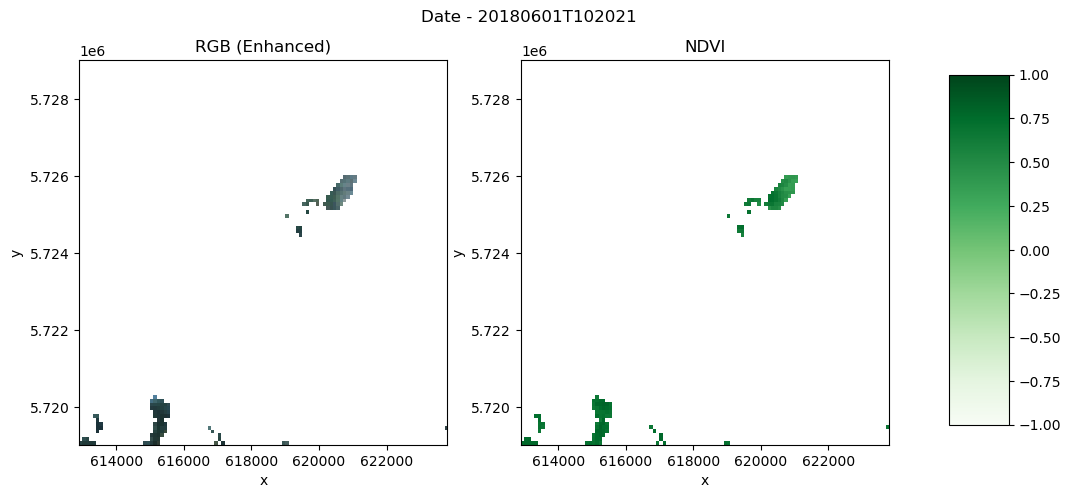

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Date - 20180601T102021\n")

# First subplot
rgb.data.plot.imshow(
    ax=ax1,
    rgb="bands",
    extent=(x_slice.start, x_slice.stop, y_slice.start, y_slice.stop),
)

ax1.set_title("RGB (Enhanced)")

# Second plot
ndvi_plot = ndvi.data.plot(ax=ax2, cmap="Greens", vmin=-1, vmax=1, add_colorbar=False)
ax2.set_title("NDVI")

# Add color bar on the right
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ndvi_plot, cax=cbar_ax)

##  Yearly mean 

In [26]:
# Group by year and compute mean
# yearly_da = bbox_reproj.groupby("time.year").mean(dim="time", skipna=True)
yearly_da = (
    cloudless_ndvi.sel(x=x_slice, y=y_slice)
    .groupby("time.year")
    .mean(dim="time", skipna=True)
)
yearly_da

<xarray.DataArray 'data' (bands: 4, year: 6, y: 100, x: 109)> Size: 2MB
dask.array<transpose, shape=(4, 6, 100, 109), dtype=float64, chunksize=(1, 1, 78, 55), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 872B 6.13e+05 6.13e+05 ... 6.236e+05 6.238e+05
  * y        (y) float64 800B 5.729e+06 5.729e+06 ... 5.719e+06 5.719e+06
  * bands    (bands) <U4 64B 'b04' 'b03' 'b02' 'ndvi'
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023
Attributes: (12/15)
    _eopf_attrs:     {'add_offset': -0.1, 'coordinates': ['x', 'y'], 'dimensi...
    add_offset:      -0.1
    dtype:           <u2
    fill_value:      0
    long_name:       BOA reflectance from MSI acquisition at spectral band b0...
    proj:bbox:       [600000.0, 5690220.0, 709800.0, 5800020.0]
    ...              ...
    proj:wkt2:       PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WG...
    scale_factor:    0.0001
    units:           digital_counts
    valid_max:       65535
    valid_min:       1
    _FillValue:      0

### Visualize NDVI for 2018

In [27]:
def plot_rgb_ndvi(dset, year, scaling, add_offset, x_slice, y_slice):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Date - " + str(year) + "\n")

    # First subplot
    rgb = dset.sel(bands=slice("b04", "b02")) * scaling_factor_b04 + add_offset_b04
    rgb = (rgb - 0.02) / (0.35 - 0.02)  # Stretch 0.02-0.35 to 0-1
    rgb = rgb.clip(0, 1)  # Clip to valid range
    rgb.plot.imshow(
        ax=ax1,
        rgb="bands",
        extent=(x_slice.start, x_slice.stop, y_slice.start, y_slice.stop),
    )
    ax1.set_title("RGB (Enhanced)")

    # Second plot
    ndvi_plot = dset.sel(bands="ndvi").plot(
        ax=ax2, cmap="Greens", vmin=-1, vmax=1, add_colorbar=False
    )
    ax2.set_title("NDVI")

    # Add color bar on the right
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(ndvi_plot, cax=cbar_ax)

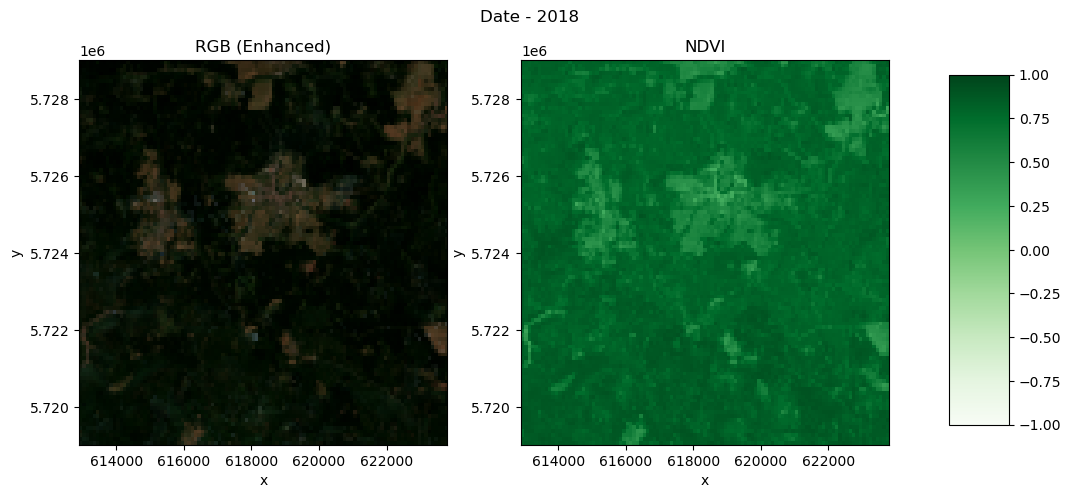

In [28]:
year = 2018
# Select year (descending y)
year = 2018  # Adjust if more years
region = yearly_da.sel(year=year, x=x_slice, y=y_slice)


plot_rgb_ndvi(region, year, scaling_factor_b04, add_offset_b04, x_slice, y_slice)

## Visualise NDVI from 2018 to 2023

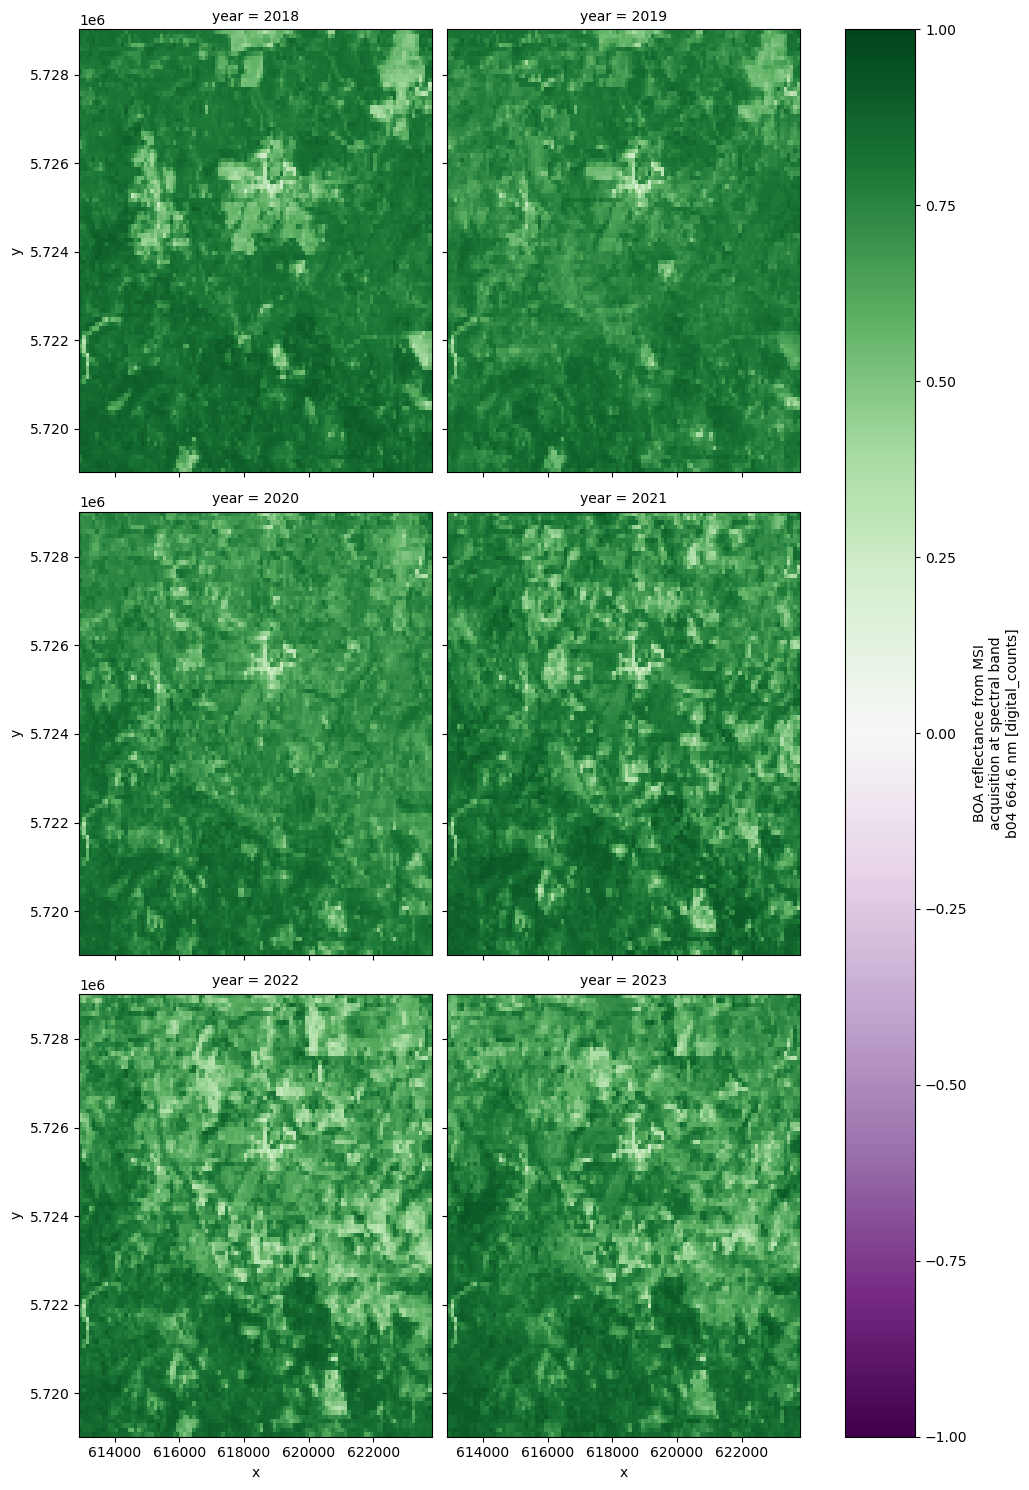

In [29]:
# Select NDVI and plot per year (smaller region for speed)
ndvi_yearly = yearly_da.sel(bands="ndvi", x=x_slice, y=y_slice).sel(
    year=slice(2018, 2023)
)

ndvi_yearly.plot(
    cmap="PRGn", x="x", y="y", col="year", col_wrap=2, vmin=-1, vmax=1, figsize=(10, 15)
)

## Create Xarray with NDVI and corresponding bands as variables

Rather than organizing the Xarray as a single DataArray with all the bands and NDVI as coordinates, we can structure it so that the coordinates represent the geographical extent of the area (x, y), and the bands become separate variables.

We create a new Xarray Dataset below with bands and NDVI as variables

In [30]:
ndvi_ds = xr.Dataset(
    {
        "NDVI": yearly_da.sel(bands="ndvi").drop_vars("bands"),
        "B04": yearly_da.sel(bands="b04").drop_vars("bands"),
        "B03": yearly_da.sel(bands="b03").drop_vars("bands"),
        "B02": yearly_da.sel(bands="b02").drop_vars("bands"),
    }
)
ndvi_ds

<xarray.Dataset> Size: 2MB
Dimensions:  (x: 109, y: 100, year: 6)
Coordinates:
  * x        (x) float64 872B 6.13e+05 6.13e+05 ... 6.236e+05 6.238e+05
  * y        (y) float64 800B 5.729e+06 5.729e+06 ... 5.719e+06 5.719e+06
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023
Data variables:
    NDVI     (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    B04      (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    B03      (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    B02      (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>

### Saving yearly NDVI into local Zarr

- Prepare dataset to be saved with a particular attention to chunks

In [31]:
region = region.to_dataset()
region.data_vars.items()

region = region.chunk({"bands": 1, "y": 50, "x": 55})
print(region)
print(region["data"].chunks)

<xarray.Dataset> Size: 351kB
Dimensions:  (x: 109, y: 100, bands: 4)
Coordinates:
  * x        (x) float64 872B 6.13e+05 6.13e+05 ... 6.236e+05 6.238e+05
  * y        (y) float64 800B 5.729e+06 5.729e+06 ... 5.719e+06 5.719e+06
  * bands    (bands) <U4 64B 'b04' 'b03' 'b02' 'ndvi'
    year     int64 8B 2018
Data variables:
    data     (bands, y, x) float64 349kB dask.array<chunksize=(1, 50, 55), meta=np.ndarray>
((1, 1, 1, 1), (50, 50), (55, 54))


In [32]:
%%time
from zarr.codecs import BloscCodec

compressor = BloscCodec(cname="zstd", clevel=3, shuffle="bitshuffle", blocksize=0)

encoding = {}

for var in region.data_vars:
    encoding[var] = {"compressors": [compressor]}
for coord in region.coords:
    encoding[coord] = {"compressors": [compressor]}
region.to_zarr("ndvi_region.zarr", zarr_format=3, encoding=encoding, mode="w")

/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/core/array.py:3989: UserWarning: The dtype `<U4` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metad

CPU times: user 3.28 s, sys: 704 ms, total: 3.98 s
Wall time: 11.3 s


## Analysis

For analysis the first step is to classify pixels as forest. In our case we will just do a simple thresholding classification where we classify everything above a certain threshold as forest. This isn't the best approach for classifying forest, since agricultural areas can also easily reach very high NDVI values. A better approach would be to classify based on the temporal signature of the pixel. 

However, for this basic analysis, we stick to the simple thresholding approach.

In this case we classify everything above an NDVI of 0.7 as forest. This calculated forest mask is then saved to a new Data Variable in the xarray dataset: 

In [33]:
ndvi_ds["FOREST"] = ndvi_ds.NDVI > 0.7

With this forest mask we can already do a quick preliminary analysis to plot the total forest area over the years.

To do this we sum up the pixels along the x and y coordinate but not along the time coordinate. This will leave us with one value per year representing the number of pixels classified as forest. We can then calculate the forest area by multiplying the number of forest pixels by the resolution.

In [34]:
def to_km2(dataarray, resolution):
    # Calculate forest area
    return dataarray * np.prod(list(resolution)) / 1e6

In [35]:
resolution = (100, 100)
forest_pixels = ndvi_ds.sel(x=x_slice, y=y_slice).FOREST.sum(["x", "y"])
forest_area_km2 = to_km2(forest_pixels, resolution)
forest_area_km2

<xarray.DataArray 'FOREST' (year: 6)> Size: 48B
dask.array<truediv, shape=(6,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023

In [36]:
forest_area_km2.load()

<xarray.DataArray 'FOREST' (year: 6)> Size: 48B
array([92.  , 88.07, 75.26, 79.14, 57.38, 69.15])
Coordinates:
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023

In [37]:
forest_area_km2

<xarray.DataArray 'FOREST' (year: 6)> Size: 48B
array([92.  , 88.07, 75.26, 79.14, 57.38, 69.15])
Coordinates:
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023

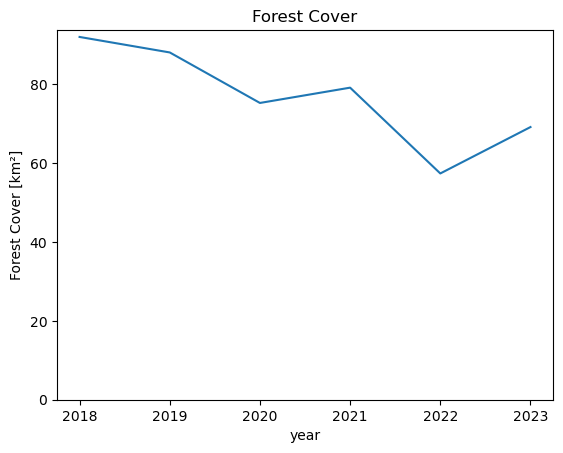

In [38]:
# forest_area_km2.sel(year=slice(2018, 2023)).plot()
forest_area_km2.plot()

plt.title("Forest Cover")
plt.ylabel("Forest Cover [km²]")
plt.ylim(0);

We can see that the total forest area in this AOI decreased from around 80 km² in 2018 to only around 50 km² in 2023.

The next step is to make change maps from year to year. To do this we basically take the difference of the forest mask of a year with its previous year.

This will result in 0 value where there has been no change, -1 where forest was lost and +1 where forest was gained.

In [39]:
# Make change maps of forest loss and forest gain compared to previous year

# 0 - 0 = No Change: 0
# 1 - 1 = No Change: 0
# 1 - 0 = Forest Gain: 1
# 0 - 1 = Forest Loss: -1

# Define custom colors and labels
colors = ["darkred", "white", "darkblue"]
labels = ["Forest Loss", "No Change", "Forest Gain"]

# Create a colormap and normalize it
cmap = mcolors.ListedColormap(colors)
norm = plt.Normalize(-1, 1)  # Adjust the range based on your data

### Use 2022 as plot_year

In [40]:
plot_year = 2022
ndvi_ds["CHANGE"] = ndvi_ds.FOREST.astype(int).diff("year", label="upper")

In [41]:
ndvi_ds["CHANGE"].compute()

<xarray.DataArray 'CHANGE' (year: 6, y: 100, x: 109)> Size: 523kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0., -1., -1., ...,  0.,  0.,  0.],
        [-1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[-1., -1.,  0., ...,  0.,  0.,  0.],
        [-1., -1., -1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  1.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [-1., -1., -1., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])
Coordinates:
  * x        (x) float64 872B 6.13e+05 6.13e+05 ... 6.236e+05 6.238e+05
  * y        (y) float64 800B 5.729e+06 5.729e+06 ... 5.719e+06 5.719e+06
  * year     (year) int64 48B 2018 2019 2020 2021 2022 2023

### Visualize the differences

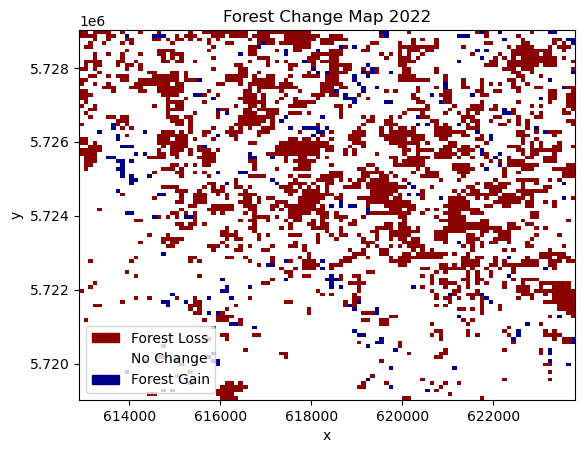

In [42]:
ndvi_ds.CHANGE.sel(year=plot_year).plot(cmap=cmap, norm=norm, add_colorbar=False)
# Create a legend with string labels
legend_patches = [
    mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)
]
plt.legend(handles=legend_patches, loc="lower left")
plt.title(f"Forest Change Map {plot_year}");

Here, we can see the spatial distribution of areas affected by forest loss. In the displayed change from 2021 to 2022, most of the forest loss happened in the northern part of the study area, while the southern part lost comparatively less forest.

To get a feel for the loss per year, we can cumulatively sum up the lost areas over the years. This should basically follow the same trends as the earlier plot of total forest area. 

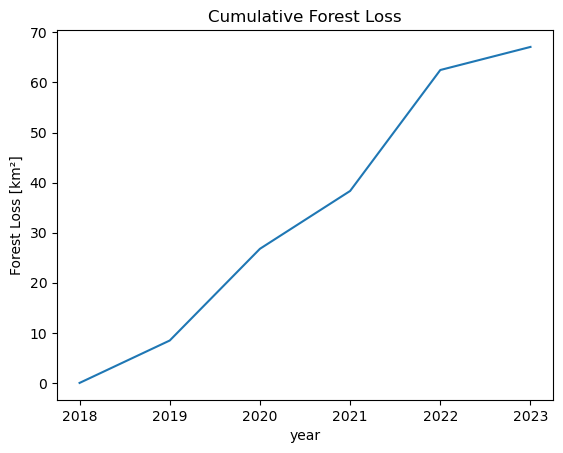

In [43]:
# Forest Loss per Year
forest_loss = (ndvi_ds.CHANGE == -1).sum(["x", "y"])
forest_loss_km2 = to_km2(forest_loss, resolution)
forest_loss_km2.cumsum().plot()
plt.title("Cumulative Forest Loss")
plt.ylabel("Forest Loss [km²]");

We can see that there have been two years with particularly large amounts of lost forest area. From 2019-2020 and with by far the most lost area between 2021 and 2022.

## Validation

Finally, we want to see how accurate our data is compared to the widely used Hansen Global Forest Change data. In a real scientific scenario, we would use Ground Truth data to assess the accuracy of our classification. In this case we use the Global Forest Change data in place of Ground Truth data, just to show how an accuracy assessment can be done. The assessment we are doing only shows how accurately we replicate the Global Forest Change data, however we will not know if our product is more or less accurate. For a more accurate assessment, actual Ground Truth data is required.

First we download the Global Forest Change Data [here](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/download.html) and open it using xarray.

In [44]:
data_path = Path("./data/")
data_path.mkdir(parents=True, exist_ok=True)
hansen_filename = "Hansen_GFC-2022-v1.10_lossyear_60N_010E.tif"
comp_data = data_path / hansen_filename

with comp_data.open("wb") as fs:
    hansen_data = requests.get(
        f"https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/{hansen_filename}"
    )
    fs.write(hansen_data.content)

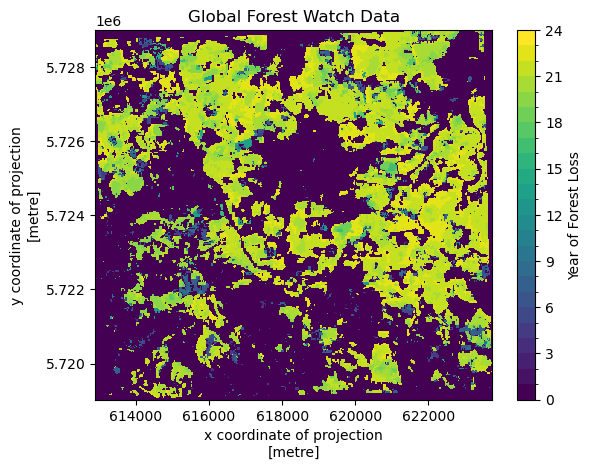

In [45]:
import matplotlib.pyplot as plt
import rioxarray

target_epsg = epsg

# Open the file (replace 'comp_data' with your raster file path)
ground_truth = (
    rioxarray.open_rasterio(comp_data)  # Replace with your file path
    .rio.clip_box(
        minx=bbox_coords[0],
        miny=bbox_coords[1],
        maxx=bbox_coords[2],
        maxy=bbox_coords[3],
    )
    .rio.reproject(target_epsg)
    .sel(band=1)
    .where(lambda gt: gt < 100, 0)  # Fill no-data (values > 100) with 0
)

# Plot
ground_truth.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Global Forest Watch Data")
plt.show()

The data shows in which year forest was first lost. To compare with our own data, we need to add the data to our dataset. To do this the data needs to have the same coordinates. This can be achieved with `.interp_like()`. This function interpolates the data to match up the coordinates of another dataset.

In this case we chose the interpolation method `nearest` since it is categorical data.

In [46]:
ndvi_ds["GROUND_TRUTH"] = ground_truth.interp_like(ndvi_ds, method="nearest").astype(
    int
)
ndvi_ds

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:237: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


<xarray.Dataset> Size: 3MB
Dimensions:       (x: 109, y: 100, year: 6)
Coordinates:
  * x             (x) float64 872B 6.13e+05 6.13e+05 ... 6.236e+05 6.238e+05
  * y             (y) float64 800B 5.729e+06 5.729e+06 ... 5.719e+06 5.719e+06
  * year          (year) int64 48B 2018 2019 2020 2021 2022 2023
    band          int64 8B 1
    spatial_ref   int64 8B 0
Data variables:
    NDVI          (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    B04           (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    B03           (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    B02           (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    FOREST        (year, y, x) bool 65kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    CHANGE        (year, y, x) float64 523kB dask.array<chunksize=(1, 22, 54), meta=np.ndarray>
    GROUND_TRUTH  (y, x) int64 87kB 0 0 0 0 0 0 ... 0 0 0 0 -9223372036854775808

The ground truth data saves the year when deforestation was first detected for a pixel in a single raster. To do this, it encodes the year of forest loss as an integer, giving the year. So, an integer 21 means the pixel was first detected as deforested in 2021, whereas a value of 0 means that deforestation was never detected.

Currently our classification saves the deforestation detection in multiple rasters, one for each year. To get our data into a format that is similar to our comparison data we need to convert our rasters for each time step into a single one.

To do this we first assign all pixels which were detected as deforestation (`CHANGE == -1`) to the year in which the deforestation was detected (`lost_year`). Then we compute over our time-series the first occurence of deforestation (equivalent to the first non-zero value) per pixel. This is then saved in a new data variable.

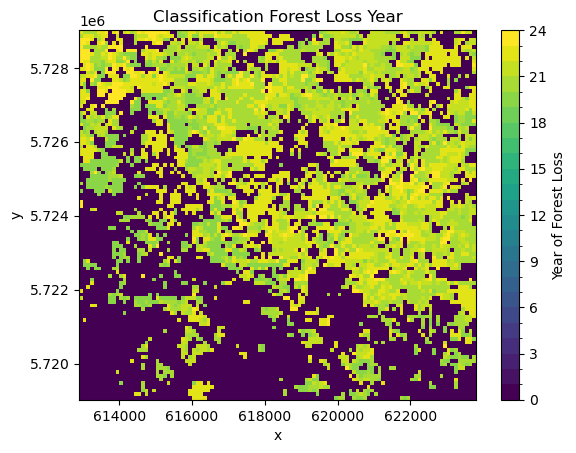

In [47]:
# convert lost forest (-1) into the year it was lost
lost_year = (ndvi_ds.CHANGE == -1) * ndvi_ds.year % 100
first_nonzero = (lost_year != 0).argmax(axis=0).compute()
ndvi_ds["LOST_YEAR"] = lost_year[first_nonzero]
ndvi_ds.LOST_YEAR.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Classification Forest Loss Year");

Comparing this visually to the Global Forest Watch data, allows us to do some initial quality assessment. We can see definite differences between the two datasets. The Global Forest Watch data has much more clearly defined borders. In general, our classification seems to overestimate deforestation. However, the general pattern of forest loss is the same in both. Most of the deforestation is in the north of the study area, with less forest loss in the south.

There are a few reasons for those differences. The main difference has to be in our much more simple approach to forest classification and change detection. It is expected that our approach will lead to large amounts of commission errors since changes are only confirmed using a single observation. It however can also lead to a lot of omission errors since the NDVI thresholding might classify highly productive non-forest areas as forest due to their high NDVI values. 

However, there are also some systematic differences. Our algorithm looks at differences between the middle of the years, which means that some changes can happen at the end of the growing year which will be detected first in the next year whereas the Global Forest Watch dataset will detect it in the correct (earlier) year.

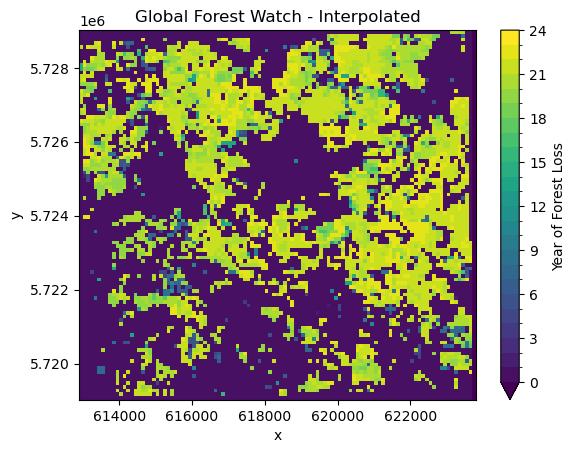

In [51]:
ndvi_ds.GROUND_TRUTH.plot(
    levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"}, cmap="viridis"
)
plt.title("Global Forest Watch - Interpolated");

Finally, we can also calculate an accuracy score. This is a score from 0-1, where values close to 0.5 basically mean that the classification is random, and values close to 1 mean that most of the values of our comparison data and classification data match.

First, we look at the overall accuracy of forest loss over the entire period from 2018 to 2023.

In [49]:
from sklearn.metrics import accuracy_score

score = accuracy_score(
    (ndvi_ds.LOST_YEAR > 18).values.ravel(), (ndvi_ds.GROUND_TRUTH > 18).values.ravel()
)
print(f"The overall accuracy of forest loss detection is {score:.2f}.")

The overall accuracy of forest loss detection is 0.76.


As expected from the visual interpretation, with an accuracy of 0.76, our product differs quite a lot compared to the Global Forest Watch data. From this we do not know for sure that our product is less accurate compared to the actual forest loss patterns observed on the ground. We only know that it is different to the Global Forest Watch product. It might be more or less accurate. 

However, because of the simplicity of our algorithm, it is safe to assume that our output is less accurate. 

## Summary

This notebook showed how to efficiently access data stored on the Copernicus Dataspace Ecosystem using the Sentinel Hub APIs. This includes generating cloud-free mosaics and calculating spectral indices in the cloud. 

It also showed how to import this data using xarray and carry out a basic multi-temporal detection of forest loss.

This notebook should serve as a starting point for your own analysis using the powerful Python Data Analysis ecosystem and leveraging the Copernicus Data Space Ecosystem APIs for quick satellite data access.

In [123]:
client.close()

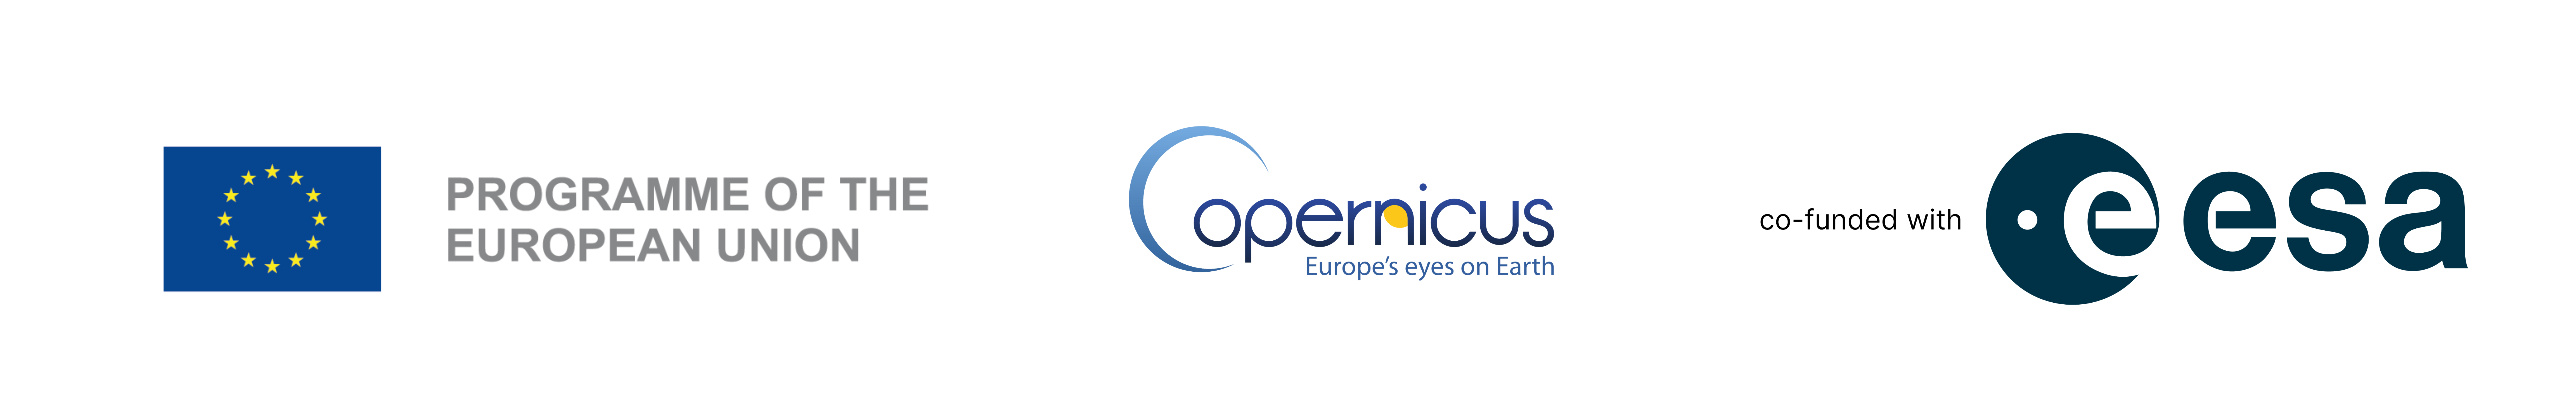